Set up the environment

In [1]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
module_path = os.path.abspath(os.path.join('../python'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label
from astropy.io import fits as fits

In [3]:
from astropy.io import fits as fits
from astropy.table import Table
from matplotlib import pyplot as plt
import matplotlib 
matplotlib.rcParams['figure.figsize']=[12,8]

In [4]:
from galsim import Image
from galsim.hsm import FindAdaptiveMom

def generate_elliptical_gaussian(e1, e2, sig, xc=128, yc=128, stamp_size=(256,256)):
    # compute centered grid
    ranges = np.array([np.arange(i) for i in stamp_size])
    x = np.outer(ranges[0] - xc, np.ones(stamp_size[1]))
    y = np.outer(np.ones(stamp_size[0]),ranges[1] - yc)
    # shift it to match centroid
    xx = (1-e1/2)*x - e2/2*y
    yy = (1+e1/2)*y - e2/2*x
    # compute elliptical gaussian
    return np.exp(-(xx ** 2 + yy ** 2) / (2 * sig ** 2))

In [5]:
#Input the directory containing the fits file
data_directory = '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/new_targets/'

#Retrieves the list of all the files
import glob

gal_files = glob.glob(data_directory+'image-*-multihdu_newtar.fits')
gal_files.sort()
print(gal_files)

['/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/new_targets/image-shfl-00-multihdu_newtar.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/new_targets/image-shfl-01-multihdu_newtar.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/new_targets/image-shfl-02-multihdu_newtar.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/new_targets/image-shfl-03-multihdu_newtar.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/new_targets/image-shfl-04-multihdu_newtar.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/new_targets/image-shfl-05-multihdu_newtar.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/new_targets/image-shfl-06-multihdu_newtar.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/new_targets/image-shfl-07-multihdu_newtar.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/new_targets/image-shfl-08-multihdu_newtar.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/new_targets/image-shfl-09-multihdu_newtar.fits', '/data/DeepDeconv/data/vsc_eu

In [243]:
gal_files[i]

'/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-10-multihdu.fits'

In [23]:
#Input the directory containing the fits file
data_directory_win = '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/window/'

#Retrieves the list of all the files
import glob
win_files = glob.glob(data_directory_win+'Gaussian_window_claire_0.fits')
win_files.sort()
print(win_files)

['/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/window/Gaussian_window_claire_0.fits']


In [6]:
from subprocess import Popen, PIPE
import numpy as np

#This transforms a mosaic in extension idx_hdu and of size (gal_dim*sqrt(ngal),gal_dim*sqrt(ngal)) into a stamp_list 
def fits2npy(fits_file, idx_hdu,gal_dim=96,nb_gal=10000):
    '''Read .fits containing the psf'''
    data = fits.getdata(fits_file, idx_hdu)
    nb_gal_row = data.shape[0]//gal_dim
    data_list = []
    idx_list = range(0, nb_gal)
    for i in idx_list:
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        data_list.append(data[x:x+gal_dim,y:y+gal_dim])
    return np.asarray(data_list)

#This translates a stamp_list [ngal,gal_dim,gal_dim,0] into a mosaic (gal_dim*sqrt(ngal),gal_dim*sqrt(ngal))
#Reverse operation of the previous function
def StampCollection2Mosaic(stamplist,gal_dim=96,nb_gal=10000):
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    mosaic=np.empty((nb_gal_row*gal_dim,nb_gal_row*gal_dim))
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        mosaic[x:x+gal_dim,y:y+gal_dim]=stamplist[i,:,:,0]
    return mosaic   



In [8]:
def makeU1(n,m):
    """Create a n x m numpy array with (i)_{i,j} entries where i is the ith
    line and j is the jth column
    INPUT: n positive integer (number of lines),
           m positive (integer number of columns)
    OUTPUT: n x m numpy array"""
    U1 = np.tile(np.arange(n),(m,1)).T
    return U1

def makeU2(n,m):
    """Create a n x m numpy array with (j)_{i,j} entries where i is the ith
    line and j is the jth column
    INPUT: n positive integer (number of lines),
           m positive (integer number of columns)
    OUTPUT: n x m numpy array"""
    U2 = np.tile(np.arange(m),(n,1))
    return U2

def makeU3(n,m):
    """Create a n x m numpy array with (1)_{i,j} entries where i is the ith
    line and j is the jth column
    INPUT: n positive integer (number of lines),
           m positive (integer number of columns)
    OUTPUT: n x m numpy array"""
    U3 = np.ones((n,m))
    return U3

def makeU4(n,m):
    """Create a n x m numpy array with (i^2+j^2)_{i,j} entries where i is the ith
    line and j is the jth column
    INPUT: n positive integer (number of lines),
           m positive (integer number of columns)
    OUTPUT: n x m numpy array"""
    U4 = np.add.outer(np.arange(n)**2,np.arange(m)**2)
    return U4

def makeU5(n,m):
    """Create a n x m numpy array with (i^2-j^2)_{i,j} entries where i is the ith
    line and j is the jth column
    INPUT: n positive integer (number of lines),
           m positive (integer number of columns)
    OUTPUT: n x m numpy array"""
    U5 = np.subtract.outer(np.arange(n)**2,np.arange(m)**2)
    return U5

def makeU6(n,m):
    """Create a n x m numpy array with (i*j)_{i,j} entries where i is the ith
    line and j is the jth column
    INPUT: n positive integer (number of lines),
           m positive (integer number of columns)
    OUTPUT: n x m numpy array"""
    U6 = np.outer(np.arange(n),np.arange(m))
    return U6

def makeUi(n,m):
    """Create a 6 x n x m numpy array containing U1, U2, U3, U4, U5 and U6
    INPUT: n positive integer (number of lines),
           m positive (integer number of columns)
    OUTPUT: 6 x n x m numpy array"""
    U1 = makeU1(n,m)
    Ul = U1**2
    Uc = Ul.T
    return np.array([U1,U1.T,makeU3(n,m),Ul+Uc,Ul-Uc,makeU6(n,m)])


In [6]:
def remove_blobs(imgbin,img,background=0,connectivity=2):
    '''Keep the biggest blob by removing the others.'''
    labels = label(imgbin,background=background,connectivity=connectivity)
    #step 1 find the biggest blob
    indices = np.unique(labels)
    sizes = np.zeros(indices.shape)
    for i in indices[1:]:
        sizes[i] = img[labels==i].sum()
    main_blob_label = np.argmax(sizes)
    main_blob_estimate = (labels==main_blob_label)*main_blob_label
    #step 2 extract mask
    mask = (labels-main_blob_estimate)==0
    return mask

In [11]:
write_path="/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/"
U=makeUi(96,96)
for i in range(17,21) :
    targets_hdu=2
    file_nb=i
    window_list=[]
    mom_list=np.zeros((10000,6))
    list_targets=fits2npy(gal_files[i],targets_hdu)
    print(i)
    for j in range(10000):
        target=list_targets[j]
        #img_res = target*(target>0)
        #thr=np.quantile(img_res,0.93)
        #tar=np.zeros_like(img_res)
        #tar[img_res>thr]=1
        #mask=tar*remove_blobs(tar,target)
        #generate W
        #W = target*mask
        W=target
        #W/=np.linalg.norm(W)
        mu=np.array([W.size/np.linalg.norm(W*(Ui.reshape((96,96))))**2/U.shape[0] for Ui in U])
        mom_list[j]=mu
        #add W to list of windows
        window_list.append(W)
    moments=np.array(mom_list)
    hdu_mom=fits.ImageHDU(data=moments)
    window_list=np.reshape(np.array(window_list),(10000,96,96,1))
    mosaic=StampCollection2Mosaic(window_list)
    hdu_win=fits.PrimaryHDU(mosaic)
    hdul = fits.HDUList([hdu_win,hdu_mom])
    mosaic_name='Target_window_claire_{0}.fits'.format(file_nb)
    hdul.writeto(write_path+'Target_Window/'+mosaic_name,overwrite=True)

17
18
19
20


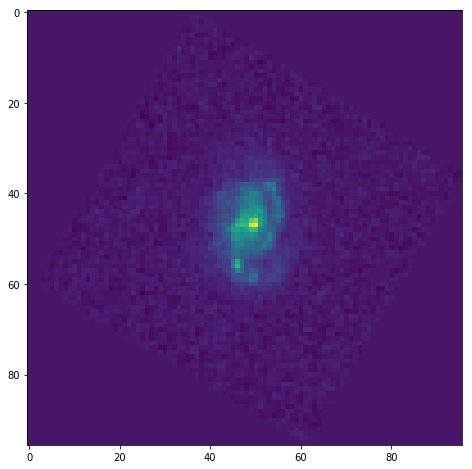

In [240]:
plt.imshow(list_targets[0])

In [11]:
write_path="/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/"

for i in range(21) :
    targets_hdu=2
    file_nb=i
    window_list=[]
    mom_list=np.zeros((10000,6))
    list_targets=fits2npy(gal_files[i],targets_hdu)
    size=list_targets[0].shape
    print(i)
    for j in range(10000):
        #we create a galsim version of Y
        Y_galsim = Image(list_targets[j])
        #we estimate the moments of Y
        mom_Y = FindAdaptiveMom(Y_galsim, strict=False)
        #we attribute Y moments to the Gaussian window W
        e1_W,e2_W = -1.*mom_Y.observed_shape.e1, mom_Y.observed_shape.e2 #convention fix: e1 sign swap
        sig_W = mom_Y.moments_sigma
        xc_W,yc_W = mom_Y.moments_centroid.y-1, mom_Y.moments_centroid.x-1 # convention fix: swap x and y and origin at (0,0)
        #generate W
        W = generate_elliptical_gaussian(e1_W, e2_W, sig_W, xc_W, yc_W, stamp_size=size)
        #W/=np.linalg.norm(W)
        U=makeUi(96,96)
        mu=np.array([W.size/np.linalg.norm(W*(Ui.reshape((96,96))))**2/U.shape[0] for Ui in U])
        mom_list[j]=mu
        #add W to list of windows
        window_list.append(W)
    moments=np.array(mom_list)
    hdu_mom=fits.ImageHDU(data=moments)
    window_list=np.reshape(np.array(window_list),(10000,96,96,1))
    mosaic=StampCollection2Mosaic(window_list)
    hdu_win=fits.PrimaryHDU(mosaic)
    hdul = fits.HDUList([hdu_win,hdu_mom])
    if i<10:
        mosaic_name='Gaussian_window_claire_0{0}.fits'.format(file_nb)
    else:
        mosaic_name='Gaussian_window_claire_{0}.fits'.format(file_nb)
    hdul.writeto(write_path+'Gaussian_Window/'+mosaic_name,overwrite=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [13]:
write_path="/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/window/"

win_hdu=0
window_list=[]
e_list=np.zeros((10000,2))

list_targets=fits2npy(win_files[0],win_hdu)
size=list_targets[0].shape
for j in range(10000):
    #we create a galsim version of Y
    Y_galsim = Image(list_targets[j])
    t=list_targets[j]
    #we estimate the moments of Y
    #mom_Y = FindAdaptiveMom(Y_galsim, strict=False)
    #we attribute Y moments to the Gaussian window W
    #e1_W,e2_W = -1.*mom_Y.observed_shape.e1, mom_Y.observed_shape.e2 #convention fix: e1 sign swap
    #sig_W = mom_Y.moments_sigma
    #xc_W,yc_W = mom_Y.moments_centroid.y-1, mom_Y.moments_centroid.x-1 # convention fix: swap x and y and origin at (0,0)
    #generate W
    #W = generate_elliptical_gaussian(e1_W, e2_W, sig_W, xc_W, yc_W, stamp_size=size)
    #W/=np.linalg.norm(W)
    m=makeUi(96,96)
    e1=(((t*m[4]).sum())*((t*m[2]).sum())-((t*m[0]).sum())**2+((t*m[1]).sum())**2)/(((t*m[4]).sum())*((t*m[2]).sum())-((t*m[0]).sum())**2-((t*m[1]).sum())**2)
    e2=2*(((t*m[5]).sum())*((t*m[2]).sum())-((t*m[0]).sum())*((t*m[1]).sum()))/(((t*m[4]).sum())*((t*m[2]).sum())-((t*m[0]).sum())**2-((t*m[1]).sum())**2)
    e_list[j]=np.array([e1,e2])
    #add W to list of windows
    #window_list.append(W)
#window_list=np.reshape(np.array(window_list),(10000,96,96,1))
#mosaic=StampCollection2Mosaic(window_list)
#hdu_win=fits.PrimaryHDU(mosaic)
#hdul = fits.HDUList([hdu_win])
#mosaic_name='Real_Gaussian_window_claire_0_denoise.fits'
#hdul.writeto(write_path+mosaic_name,overwrite=True)

In [16]:
sum_e=[]
for i in range(10000): 
    sum_e.append(e_list[i][0]+1j*e_list[i][1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


(array([1.55480e+04, 1.15054e+05, 4.29390e+04, 1.74100e+04, 1.44440e+04,
        3.90700e+03, 6.55000e+02, 3.90000e+01, 3.00000e+00, 1.00000e+00]),
 array([0.22574298, 0.30173683, 0.37773067, 0.45372451, 0.52971835,
        0.60571219, 0.68170603, 0.75769987, 0.83369372, 0.90968756,
        0.9856814 ]),
 <a list of 10 Patch objects>)

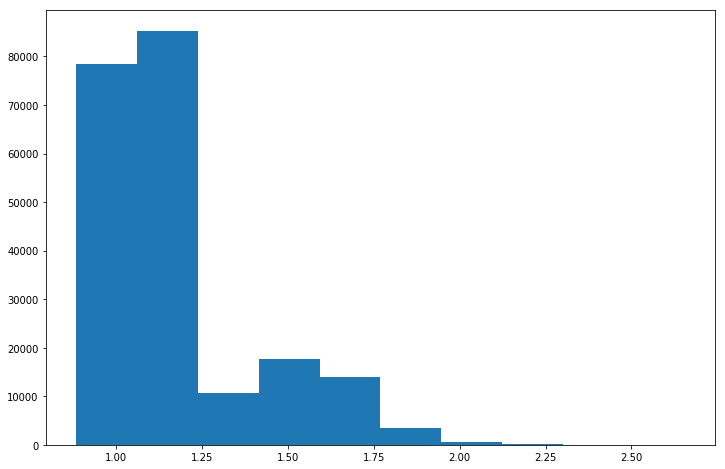

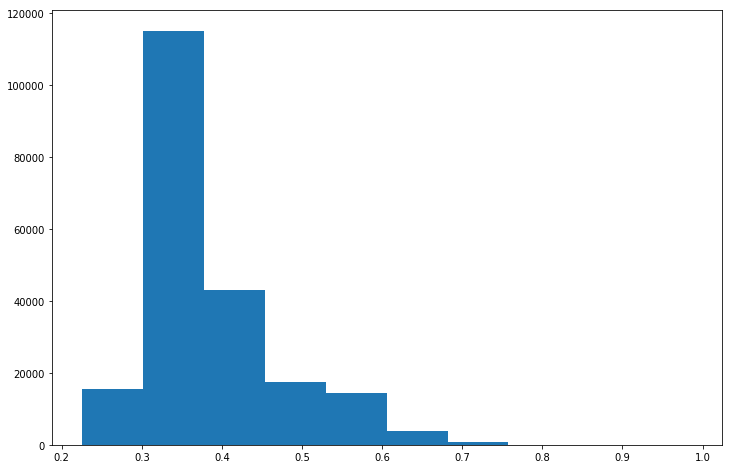

In [253]:
l=[]
lc=[]
for i in range(21):
    print(i)
    if i<10:
        old_tar_name='/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-0{0}-multihdu.fits'.format(i)
    else:
        old_tar_name='/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-{0}-multihdu.fits'.format(i)
    old_tar=fits2npy(old_tar_name,2)
    new_tar_name='/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/window/Gaussian_window_claire_{0}.fits'.format(i)
    new_tar=fits2npy(new_tar_name,0)
    for j in range(10000):
        l.append(np.linalg.norm(old_tar[j]-new_tar[j]))
        lc.append(np.linalg.norm(old_tar[j,35:62,35:62]-new_tar[j,35:62,35:62]))
        
plt.hist(l)
plt.figure()
plt.hist(lc)

(array([ 178., 2648., 4027., 1358.,  527.,  643.,  400.,  158.,   49.,
          12.]),
 array([0.22574298, 0.28001395, 0.33428491, 0.38855587, 0.44282683,
        0.49709779, 0.55136875, 0.60563971, 0.65991067, 0.71418163,
        0.76845259]),
 <a list of 10 Patch objects>)

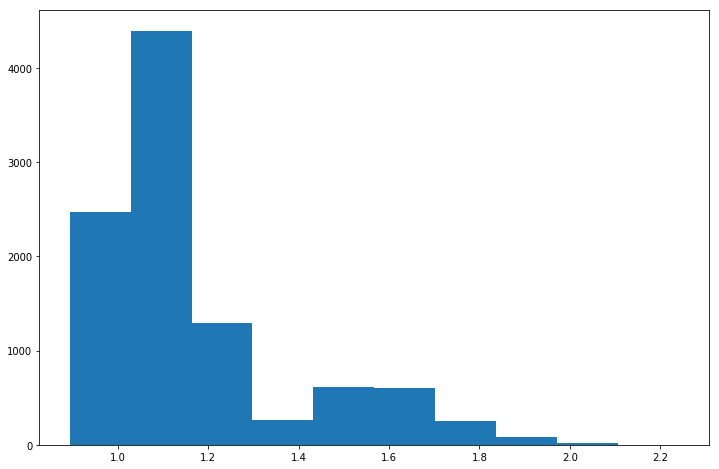

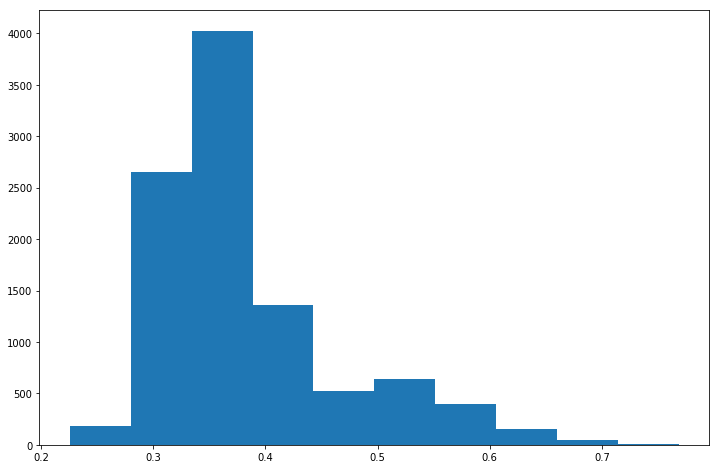

In [195]:
l=[]
lc=[]
old_tar_name='/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-0-multihdu.fits'
old_tar=fits2npy(old_tar_name,2)
new_tar_name='/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/window/Gaussian_window_claire_0.fits'
new_tar=fits2npy(new_tar_name,0)
for j in range(10000):
    l.append(np.linalg.norm(old_tar[j]-new_tar[j]))
    lc.append(np.linalg.norm(old_tar[j,35:62,35:62]-new_tar[j,35:62,35:62]))
        
plt.hist(l)
plt.figure()
plt.hist(lc)

In [ ]:
np.where(np.array(lc)>0.7)

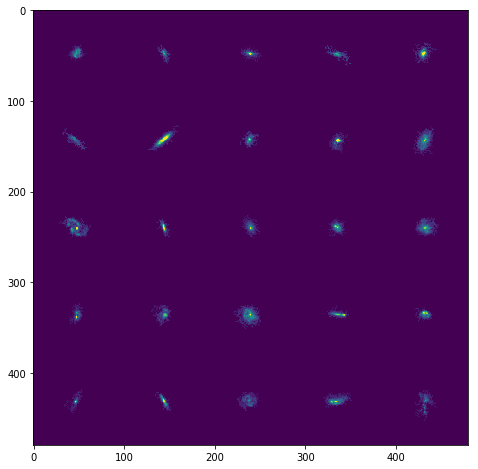

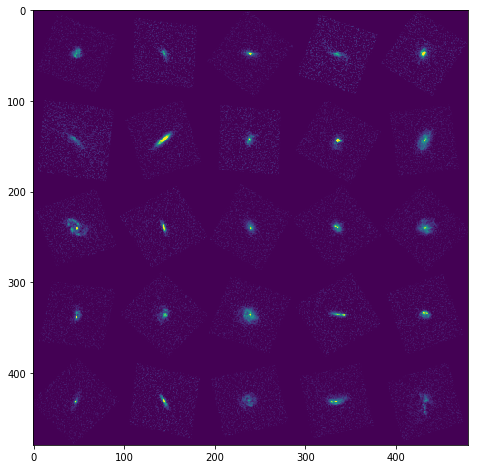

In [277]:
old_tar_name='/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-20-multihdu.fits'
old_tar=fits.getdata(old_tar_name,2)
new_tar_name='/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/window/Gaussian_window_claire_20.fits'
new_tar=fits.getdata(new_tar_name,0)
plt.imshow(new_tar[0*96:5*96,0*96:5*96],vmin=0,vmax=0.5)
plt.figure()
plt.imshow(old_tar[0*96:5*96,0*96:5*96],vmin=0,vmax=0.5)


In [38]:
%matplotlib inline
plt.rcParams['figure.figsize']=[15,8]

<Figure size 864x576 with 0 Axes>

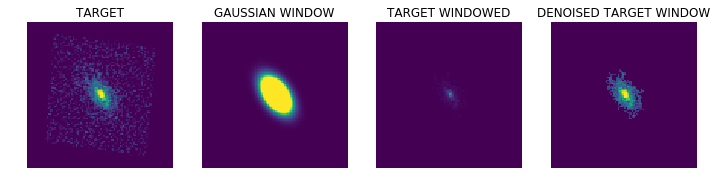

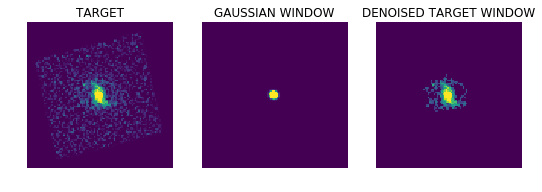

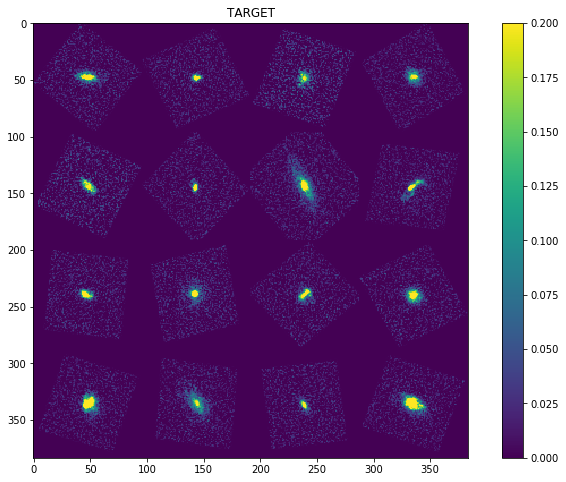

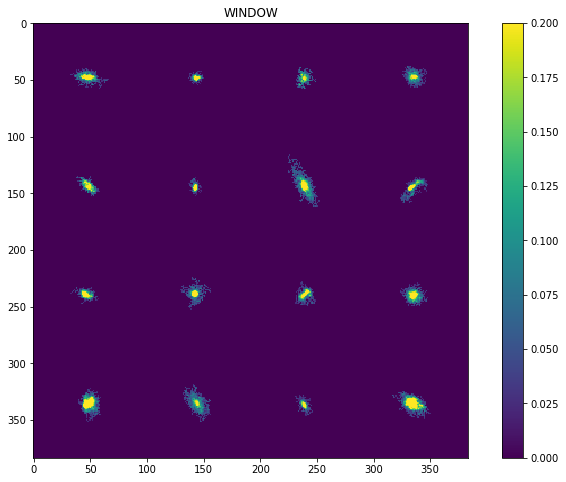

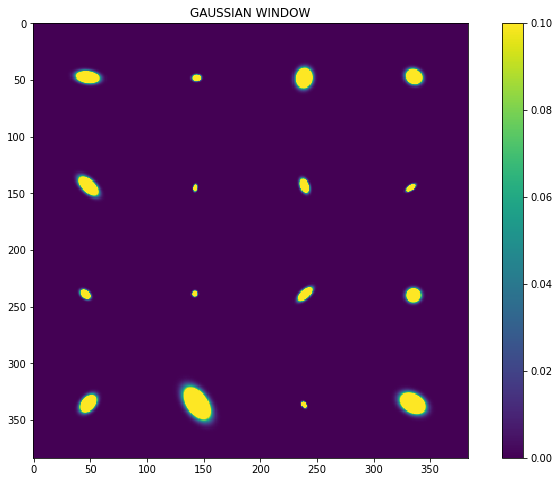

<Figure size 864x576 with 0 Axes>

In [10]:
import numpy as np
target=fits.getdata("/data/DeepDeconv/benchmark/claire/images/image-shfl-0-multihdu-target_fwhm0p07.fits",0)
window=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/window/Gaussian_window_claire_0.fits",0)
gwindow=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/window/Real_Gaussian_window_claire_0.fits",0)
target_gwindowed=target*gwindow

plt.figure(1)
plt.subplot(141)
plt.imshow(target[768+768-96:768+768,768+384+96:768+768-192],vmin=0,vmax=0.2)
plt.axis('off')
plt.title("TARGET")
plt.subplot(142)
plt.imshow(gwindow[768+768-96:768+768,768+384+96:768+768-192],vmin=0,vmax=0.2)
plt.axis('off')
plt.title("GAUSSIAN WINDOW")
plt.subplot(143)
plt.imshow(target_gwindowed[768+768-96:768+768,768+384+96:768+768-192],vmin=0,vmax=0.2)
plt.axis('off')
plt.title("TARGET WINDOWED")
plt.subplot(144)
plt.imshow(window[768+768-96:768+768,768+384+96:768+768-192],vmin=0,vmax=0.2)
plt.axis('off')
plt.title('DENOISED TARGET WINDOW')
plt.figure(2)
plt.subplot(141)
plt.imshow(target[768-96:768,384+96:768-192],vmin=0,vmax=0.2)
plt.axis('off')
plt.title("TARGET")
plt.subplot(142)
plt.imshow(gwindow[768-96:768,384+96:768-192],vmin=0,vmax=0.1)
plt.axis('off')
plt.title("GAUSSIAN WINDOW")
plt.subplot(143)
plt.imshow(window[768-96:768,384+96:768-192],vmin=0,vmax=0.2)
plt.axis('off')
plt.title('DENOISED TARGET WINDOW')



plt.figure()
plt.imshow(target[768+384:768+768,768+384:768+768],vmin=0,vmax=0.2)
plt.title("TARGET")
plt.colorbar()
plt.figure()
plt.imshow(window[768+384:768+768,768+384:768+768],vmin=0,vmax=0.2)
plt.title("WINDOW")
plt.colorbar()
plt.figure()
plt.imshow(gwindow[768+384:768+768,768+384:768+768],vmin=0,vmax=0.1)
plt.title("GAUSSIAN WINDOW")
plt.colorbar()
plt.figure()





In [14]:
from astropy.table import Table

for i in range(1) :
    targets_hdu=2
    file_nb=i
    window_list=[]
    mom_list=np.zeros((10,6))
    list_targets=fits2npy(gal_files[i],targets_hdu)
    for j in range(10):
        #we create a galsim version of Y
        Y_galsim = Image(list_targets[j])   #modifier 
        #we estimate the moments of Y
        mom_Y = FindAdaptiveMom(Y_galsim, strict=False)
        #we attribute Y moments to the Gaussian window W
        e1_W,e2_W = -1.*mom_Y.observed_shape.e1, mom_Y.observed_shape.e2 #convention fix: e1 sign swap
        sig_W = mom_Y.moments_sigma
        xc_W,yc_W = mom_Y.moments_centroid.y-1, mom_Y.moments_centroid.x-1 # convention fix: swap x and y and origin at (0,0)
        #generate W
        W = generate_elliptical_gaussian(e1_W, e2_W, sig_W, xc_W, yc_W, stamp_size=(96,96))
        W/=np.linalg.norm(W)
        U=makeUi(96,96)+1
        mu=np.array([W.size/np.linalg.norm(W*Ui)**2/U.shape[0] for Ui in U])
        mom_list[j]=mu
        #add W to list of windows
        window_list.append(W)
    moments=np.array(mom_list)
    hdu_mom=fits.ImageHDU(data=moments)







In [23]:
im=np.random.randn(10000,96,96,1)
target=np.zeros((10000,96,96,1))
mosaic_t=StampCollection2Mosaic(target)
hdu_t=fits.PrimaryHDU(mosaic_t)
mosaic_im=StampCollection2Mosaic(im)
hdu_im=fits.PrimaryHDU(mosaic_im)
mosaic_t_name='target_zero.fits'
hdu_t.writeto(write_path+'window/'+mosaic_t_name,overwrite=True)
mosaic_im_name='noise.fits'
hdu_im.writeto(write_path+'window/'+mosaic_im_name,overwrite=True)



In [21]:

hdu_win.data.shape

(9600, 9600)

In [13]:
#Retrieves the list of all the files
import glob

gal_files = glob.glob(data_directory+'image-*-multihdu.fits')
gal_files.sort()
print(gal_files)

win_files = glob.glob(write_path+'window/'+'Gaussian*')
win_files.sort()
print(win_files)


['/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-0-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-1-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-10-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-11-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-12-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-13-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-14-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-15-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-16-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-17-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-18-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-19-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-2-mult

In [15]:
file_inspect=0
sl=(slice(0,384),slice(0,384))
mosaic_gal=fits.getdata(gal_files[file_inspect],targets_hdu)
mosaic_win=fits.getdata(win_files[file_inspect],0)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd654850978>,
 <matplotlib.image.AxesImage at 0x7fd6547b1b70>)

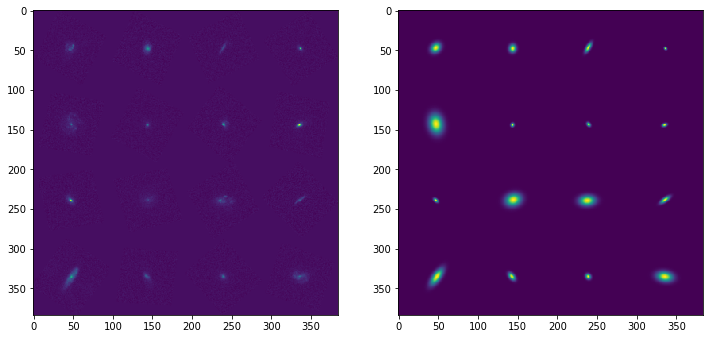

In [38]:
plt.figure(figsize=[12,8])
plt.subplot(121),plt.imshow(mosaic_gal[sl])
plt.subplot(122),plt.imshow(mosaic_win[sl])


In [20]:
np.max(np.abs(mosaic_win))

0.36787944117144233

In [101]:
np.shape(np.concatenate((np.reshape(mosaic_gal,(9600,9600,1)),np.reshape(mosaic_win,(9600,9600,1))),2))


[[1, 2], [3, 4]]

In [77]:
U=makeUi(4,4)
U

array([[[ 0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.],
        [ 2.,  2.,  2.,  2.],
        [ 3.,  3.,  3.,  3.]],

       [[ 0.,  1.,  2.,  3.],
        [ 0.,  1.,  2.,  3.],
        [ 0.,  1.,  2.,  3.],
        [ 0.,  1.,  2.,  3.]],

       [[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.]],

       [[ 0.,  1.,  4.,  9.],
        [ 1.,  2.,  5., 10.],
        [ 4.,  5.,  8., 13.],
        [ 9., 10., 13., 18.]],

       [[ 0., -1., -4., -9.],
        [ 1.,  0., -3., -8.],
        [ 4.,  3.,  0., -5.],
        [ 9.,  8.,  5.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  1.,  2.,  3.],
        [ 0.,  2.,  4.,  6.],
        [ 0.,  3.,  6.,  9.]]])